# PACKAGES IMPORT AND ENVIRONMENT SETUP


In [2]:
#seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
#np.random.seed(seed)

import logging

import random
random.seed(42)

In [3]:
seed1=42# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import initializers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed1)
tf.compat.v1.set_random_seed(seed1)
print(tf.__version__)

2.13.0


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

In [5]:
TRAIN_DIR="/kaggle/input/notebookdbd36529ff/data/training_folder"
VAL_DIR="/kaggle/input/notebookdbd36529ff/data/validation_folder"
TEST_DIR="/kaggle/input/notebookdbd36529ff/data/test_folder"
IMG_SHAPE=(96,96)
BATCH_SIZE=32

# IMPORT IMAGES FROM DIRECTORY


In [6]:
import glob
import cv2

In [7]:
training_h='/kaggle/input/notebookdbd36529ff/data/training_folder/healthy/*.jpg'
training_un='/kaggle/input/notebookdbd36529ff/data/training_folder/unhealthy/*.jpg'
validation_h='/kaggle/input/notebookdbd36529ff/data/validation_folder/healthy/*.jpg'
validation_un='/kaggle/input/notebookdbd36529ff/data/validation_folder/unhealthy/*.jpg'
test_h='/kaggle/input/notebookdbd36529ff/data/test_folder/healthy/*.jpg'
test_un='/kaggle/input/notebookdbd36529ff/data/test_folder/unhealthy/*.jpg'

obj_tr_h=glob.glob(training_h)
obj_tr_un=glob.glob(training_un)
obj_val_h=glob.glob(validation_h)
obj_val_un=glob.glob(validation_un)
obj_ts_h=glob.glob(test_h)
obj_ts_un=glob.glob(test_un)

In [9]:
y_train_h=[]

y_train_unh=[]

x_train=[]

y_train=[]

x_train_h=[]

x_train_unh=[]

for el in obj_tr_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_train_h.append(im)
    x_train.append(im)
    y_train.append([np.float32(0)])
    y_train_h.append(np.array([float(1) , float(0) ]))



for el in obj_tr_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_train_unh.append(im)
    x_train.append(im)
    y_train.append([np.float32(1)])
    y_train_unh.append(np.array([float(0),float(1)]) )




shuffle_indexes=np.arange(len(y_train))
#np.random.seed=seed
np.random.shuffle(shuffle_indexes)

#x_train_h=np.array(x_train_h)
#y_train_h=np.array(y_train_h)

#x_train_unh=np.array(x_train_unh)
#y_train_unh=np.array(y_train_unh)

x_train=np.array(x_train)
y_train=np.array(y_train)

x_train=x_train[shuffle_indexes]
y_train=y_train[shuffle_indexes]


In [10]:
x_train_h[0].shape
y_train_h[0]

array([1., 0.])

In [11]:
y_val=[]


x_val=[]

for el in obj_val_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_val.append(im)
    y_val.append([np.float32(0)])


for el in obj_val_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_val.append(im)
    y_val.append([np.float32(1)])


shuffle_indexes=np.arange(len(y_val))
np.random.seed=42
np.random.shuffle(shuffle_indexes)

x_val=np.array(x_val)
y_val=np.array(y_val)


x_val=x_val[shuffle_indexes]
y_val=y_val[shuffle_indexes]


# CHECK HEALTHY/UNHEALTHY IMAGES


In [ ]:
num_img=10

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(x_train_h[i]/255)
    ax = axes[1,i%num_img]
    ax.imshow(np.clip(x_train_unh[i]/255, 0, 1))
plt.tight_layout()
plt.show()

In [12]:
y_test=[]


x_test=[]

for el in obj_ts_h:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_test.append(im)
    y_test.append([np.float32(0)])


for el in obj_ts_un:
    im=cv2.cvtColor(cv2.imread(el), cv2.COLOR_BGR2RGB)
    x_test.append(im)
    y_test.append([np.float32(1)])


shuffle_indexes=np.arange(len(y_test))
np.random.seed=42
np.random.shuffle(shuffle_indexes)

x_test=np.array(x_test)
y_test=np.array(y_test)


x_test=x_test[shuffle_indexes]
y_test=y_test[shuffle_indexes]


In [13]:
print(len(x_train_h))
print(len(x_train_unh))
print(len(y_train_h))
print(len(y_train_unh))

print(x_val.shape)
print(y_val.shape)

2210
1293
2210
1293
(619, 96, 96, 3)
(619, 1)


In [14]:
x_train.shape , y_train.shape  ,  x_val.shape  ,  y_val.shape


((3503, 96, 96, 3), (3503, 1), (619, 96, 96, 3), (619, 1))

In [ ]:
input_shape=(96,96,3)

regularizer = tfk.regularizers.l2(0.8)
def create_encoder():
    resnet = tfk.applications.ResNet50V2(
        include_top=False, weights="imagenet", input_shape=input_shape, pooling="avg"
    )

    for layer in resnet.layers:
        if isinstance(layer, tfkl.Conv2D):
            layer.kernel_regularizer = regularizer

    inputs = tfk.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = tfk.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")





    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 64
hidden_units = 312
projection_units = 128
num_epochs = 15
dropout_rate = 0.5
temperature = 0.1

In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = tfk.Input(shape=(96,96,3))
    features = encoder(inputs)
    features = tfkl.Dropout(0.4)(features)
    features = tfkl.Dense(hidden_units , kernel_regularizer=tfk.regularizers.l2(0.8))(features)
    norm=tfkl.BatchNormalization()(features)
    activ=tfkl.Activation("relu")

    features = tfkl.Dropout(0.4)(features)
    outputs = tfkl.Dense(2, activation="softmax" , kernel_regularizer=tfk.regularizers.l2(0.1) )(features)

    model = tfk.Model(inputs=inputs, outputs=outputs, name="classs")
    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


In [ ]:
Y_tr

In [ ]:
Y_tr[:,1]

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_tr, y=Y_tr, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

# SPERVISED

In [16]:
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [17]:
def mixup_im(train_ds_one , train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = 0.4
    beta = 0.4

    # Get a sample from the Beta distribution
    lambda_value = np.random.beta(alpha, beta,1)



    image=image1*lambda_value+image2*(1-lambda_value)
    labelA = label1[0] * lambda_value + label2[0] * (1 - lambda_value)
    labelB = label1[1] * lambda_value + label2[1] * (1 - lambda_value)
    label=np.array([labelA[0],labelB[0]])

    return image,label


In [19]:
def Random_OverSampler( X_h,Y_h , X_unh , Y_unh , n_h=3000 , n_mix=4000):
        
        
        
        x_h=[]
        y_h=[]
        x_unh=[]
        y_unh=[]
        
        
        
        x_mix=[]
        y_mix=[]
        
        len_h=len(X_h)
        len_unh=len(X_unh)
        
        h_indexes=np.arange(len_h)
        un_indexes=np.arange(len_unh)
        
        
        # Mixup intraclass H
        for i in range(n_h):
            idx1,idx2=np.random.choice(h_indexes , 2 , replace=False)
            
            
            im1=X_h[idx1]
           
            lbel1=Y_h[idx1]
            
            
            im2=X_h[idx2]
            lbel2=Y_h[idx2]
            
            im,lab=mixup_im((im1,lbel1) , (im2 , lbel2))
            
            x_h.append(im)

            
            y_h.append(lab)
            
         # Mixup intraclass UNH
            
        n_unh=len_h+n_h-len_unh
            
        for i in range(n_unh):
            idx1,idx2=np.random.choice(un_indexes , 2 , replace=False)
            
            im1=X_unh[idx1]
            lbel1=Y_unh[idx1]
            
            
            im2=X_unh[idx2]
            lbel2=Y_unh[idx2]
            
            im,lab=mixup_im((im1,lbel1) , (im2 , lbel2))
            
            x_unh.append(im)
            
            y_unh.append(lab)
            
            
            
        # Mixup interclass
        
        
        for i in range(n_mix):
            idx1=np.random.choice(h_indexes , 1 )[0]
            idx2=np.random.choice(un_indexes,1)[0]
            
            
            im1=X_h[idx1]
            lbel1=Y_h[idx1]
            
            
            im2=X_unh[idx2]
            lbel2=Y_unh[idx2]
            
            im,lab=mixup_im((im2 , lbel2)  ,  (im1,lbel1))
            
            x_mix.append(im)
            
            y_mix.append(lab)
            
            

        
        print("X_h", len(X_h),len(X_h[0]),type(X_h) , type(X_h[0]))
        print("X_unh", len(X_unh),len(X_unh[0]),  type(X_unh),type(X_unh[0]))
        print("x_h", len(x_h),len(x_h[0]) , type(x_h),type(x_h[0]))
        print("x_unh", len(x_unh),len(x_unh[0]), type(x_unh),type(x_unh[0]))
        print("x_mix",len(x_mix),len(x_mix[0]) , type(x_mix),type(x_mix[0]))
        
        X=X_h+X_unh+x_h+x_unh+x_mix
        Y=Y_h+Y_unh+y_h+y_unh+y_mix
        
        X=np.array(X)
        Y=np.array(Y)
        
        

        
        return X,Y
        
        
        
        
        

In [20]:
x_tr,Y_tr=Random_OverSampler(x_train_h ,y_train_h , x_train_unh , y_train_unh  ,n_h=100 ,n_mix=1000)


X_h 2210 96 <class 'list'> <class 'numpy.ndarray'>
X_unh 1293 96 <class 'list'> <class 'numpy.ndarray'>
x_h 100 96 <class 'list'> <class 'numpy.ndarray'>
x_unh 1017 96 <class 'list'> <class 'numpy.ndarray'>
x_mix 1000 96 <class 'list'> <class 'numpy.ndarray'>


In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train generator with augmentation
train_image_gen  = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(0.7,1.25),
    
    #shear_range=0.15,
    zoom_range=0.0,
    #channel_shift_range=1,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,)

train_dataset = train_image_gen.flow(x_tr,Y_tr ,batch_size=32, shuffle=True)


val_generator=ImageDataGenerator()

val_dataset = val_generator.flow(x_val,y_val ,batch_size=32, shuffle=False)



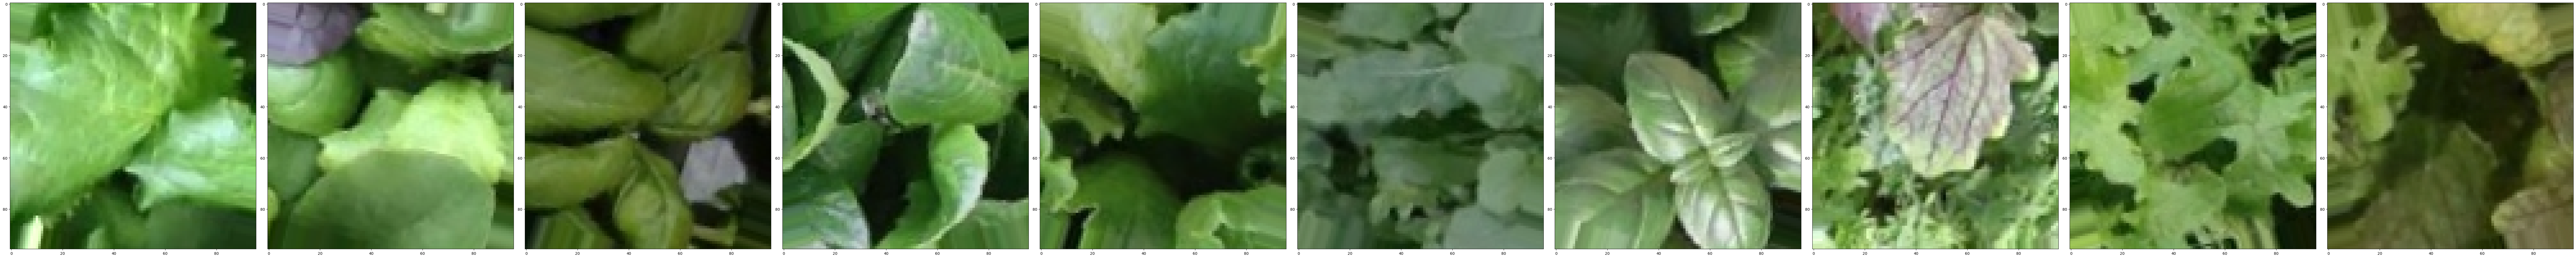

In [83]:
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(96, 96))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(train_dataset[0][0][i]/255)
 

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# BOOSTING


In [22]:
!pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata


In [ ]:
#y_train=tf.keras.utils.to_categorical(y_train, num_classes=2)

In [46]:
import math as m
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten


class Adaboost_classifier:

    def __init__(self, x, y , threshold , repetitions ):

        #self.base_classifier=base_classifier
        self.x=x
        self.y=y
        self.t=threshold
        self.runs=repetitions

        self.classifiers=[]

        self.n=self.x.shape[0]

        self.weights=np.ones(x.shape[0])/self.n

        self.classifiers_weights=[]

        self.final_class=None




    def randSample(self):

        indexes=np.arange(self.n)

        boots=np.random.choice(a=indexes,size=self.n ,replace=True , p=self.weights)

        return self.x[boots] , self.y[boots]


    def boosting(self):



        for i in range(self.runs):

                # creation of weak classifier
                model= BaseCNN()


                # random sampling with replacement using self.weights as sample probabilities
                x,y=self.randSample()


                # train the weak classifier on x,y
                model.train(x,y)

                #predict the whole dataset and observe results
                pred_t=model.predict(self.x)

                results=(pred_t==self.y[:,1])

                # compute the weighted error rate of the base classifier
                e_t=self.weighted_err_rate(self.y[:,1] , pred_t)
                print(e_t)



                # if error rate=0 then stop
                if e_t==0: break

                # if error rate is less than 0.5 then
                if e_t<self.t:

                    # collect the classifier
                    self.classifiers.append(model)

                    # compute the classifier weight
                    alpha_t=m.log((1-e_t)/e_t)

                    # collect the classifier weight
                    self.classifiers_weights.append(alpha_t)

                    # update the sample data point probabilites: increase probability for misclassified data points
                    for j in range(self.n):
                        if not(results[j]):

                            self.weights[j]=self.weights[j]*((1-e_t)/e_t)
                    # normalize probabilities into range [0,1]
                    self.normalize_weights()

        # combine the classifiers to obtain a single classifier
        self.final_class=self.return_final_class()






# auxiliary functions

    def weighted_err_rate(self , y_true , y_pred):

        et=0

        vals=(y_true!=y_pred)

        for i in range(self.n):

            et=et+self.weights[i]*vals[i]

        return et


    def normalize_weights(self):

        tot=np.sum(self.weights)

        self.weights=self.weights/tot


    def return_final_class(self):

        model_input = tfk.Input(shape=(96, 96, 3))
        model_outputs = [model.model(model_input) for model in self.classifiers]



        ensemble_output = WeightedAverageLayer(self.classifiers_weights) (model_outputs)
        ensemble_model=tfk.Model(inputs=model_input, outputs=ensemble_output)

        return ensemble_model




class WeightedAverageLayer(tfk.layers.Layer):
    def __init__(self, W, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.W=W

    def call(self, inputs):

        to_ret=self.W[0]*inputs[0]

        for i in range(1,len(self.W)):
             to_ret+=self.W[i]*inputs[i]
        return to_ret
#ensemble_output = WeightedAverageLayer(0.8, 0.8, 0.75, 0.76, 0.74, 0.78, 0.76) (model_outputs)
#ensemble_model = tfk.Model(inputs=model_input, outputs=ensemble_output)







class BaseCNN:
    def __init__(self, input_shape=(96,96,3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=self.input_shape))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(2, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self,x,y):

        self.model.fit(x, y, epochs=1, verbose=0)


    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return np.argmax(y_pred, axis=1)






 CNN is too sensitive to changes in the data and Adaboost technique requires a more stable classifier, so it is not effective as we can se below. Just the first CNNs achive an error rate<0.5

In [47]:


Class=Adaboost_classifier(x_tr,Y_tr,0.50,10)

Class.boosting()
#Class.y.shape
#Class.classifiers_weights

176/176 [==============================] - 1s 5ms/step
0.5864768683273752
176/176 [==============================] - 1s 5ms/step
0.5060498220640378
176/176 [==============================] - 1s 5ms/step
0.5430604982206179
176/176 [==============================] - 1s 5ms/step
0.5832740213522866
176/176 [==============================] - 1s 5ms/step
0.5807829181494398
176/176 [==============================] - 1s 5ms/step
0.5733096085408996
176/176 [==============================] - 1s 5ms/step
0.5540925266903677
176/176 [==============================] - 1s 5ms/step
0.588967971530222
176/176 [==============================] - 1s 5ms/step
0.471708185053365
176/176 [==============================] - 1s 5ms/step
0.5301039192998774


In [49]:
preds=np.argmax(Class.final_class.predict(x_test), axis=1)

23/23 [==============================] - 0s 4ms/step


In [50]:
predictions=preds
y_pred=preds
y_true=y_test[:,1]


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Confusion Matrix:
[[305 154]
 [146 123]]
Accuracy: 0.5879120879120879
Precision: 0.44404332129963897
F1 Score: 0.45054945054945056
Recall: 0.45724907063197023
